# An Exploration of the Statsmodels library

We have seen that sci-kit has some amazing libraries for machine learning. If you want to perform statistical analysis of your data there are many great libraries at your disposal (eg : scipy's stats) and Statsmodels is one such powerful library for statistical analysis of your data.

Statsmodel has a neat and straightforward representation of most statistical results that you would expect to see and this appeals to me the most. Further, the library has a nice R-style formula framework that makes things very convenient (as you shall see)

It might cross your mind as you read this tutorial that many of the functions discussed here could be achieved with a few other libraries. Nevertheless, statmodels is amazing for its simplicity and is definitely one of the libraries that a data-scientist should have in his toolbox. 

In this tutorial, I will apply Statsmodels in a regression context to highlight its utility. A detailed documentation of the package can be found at - https://www.statsmodels.org/stable/gettingstarted.html

## Installation 

To get started, you can install Statsmodels with pip using the following command : 

    pip install --upgrade --no-deps statsmodels

The conda installation command is : 

    conda install statsmodels 

 
 

In [37]:
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd
import patsy

# Data

Let us first begin by loading our dataset. The datasets that we will use for this tutorial is derived from the 'Open University Learning Analytics' (OULAD) dataset (ref: https://analyse.kmi.open.ac.uk/open_dataset). The dataset contains 2 years of data from an online learning environment that includes information on student demorgraphics, their performance in assessments and interactions with the virtual environment itself.

The dataset compiled contains student information, their performance measured by weighted scores (wscores) and their level of interaction with the course measured my the number of clicks (sum_click) for each course that the student undertook. Here is a short description of the variables.
- code_module : the course id
- code_presentation : the semester in which the course was held
- region : student's location
- highest_education : educational background of the student
- age_band : student age group


In [38]:
scores_df =  pd.read_csv('student_scores.csv')
scores_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,age_band,disability,wscore,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,55<=,N,16.48,934
1,AAA,2013J,28400,F,Scotland,HE Qualification,35-55,N,13.08,1435
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,35-55,N,15.26,2158
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,0-35,N,11.00,1034
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,35-55,N,13.38,2445


Intuitively, it is reasonable to suspect a positive relationship between student performance (wscore) and online interaction (sum_click). 

Let us take a look at this relationship by plotting wscores against sum_click for all the courses in both years (2013 & 2014) and the same semester

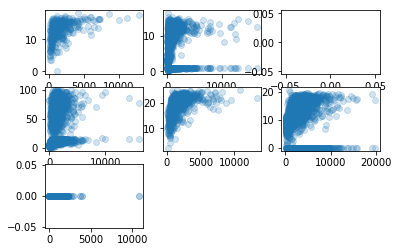

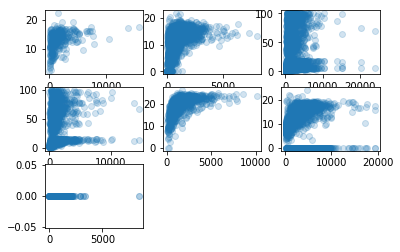

In [39]:
modules = scores_df['code_module'].unique() #['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'] -> all courses
modules
i = 1
for m in modules:
    d1 = scores_df[(scores_df['code_module'] == m)&(scores_df['code_presentation'] == '2013J')]
    plt.subplot(3, 3, i)
    plt.scatter(d1['sum_click'],d1['wscore'], alpha=0.2) 
    i = i+1
plt.show()

i = 1
for m in modules:
    d1 = scores_df[(scores_df['code_module'] == m)&(scores_df['code_presentation'] == '2014J')]
    plt.subplot(3, 3, i)
    plt.scatter(d1['sum_click'],d1['wscore'], alpha=0.2) 
    i = i+1
plt.show()


In most of the plots there seems to exists some positive relationship between clicks and scores. We will focus on code presentation - 'AAA' (the first subplot in each case above) to carry out our regression analysis as it presents the best case.

In [40]:
class_scores_df = scores_df[(scores_df['code_module'] == 'AAA')] #extracting data corresponding to 'AAA'
cols = ['highest_education', 'age_band', 'sum_click', 'wscore'] #choosing columns that we are interested in
class_scores_df = class_scores_df[cols]
class_scores_df.head()

,highest_education,age_band,sum_click,wscore
0,HE Qualification,55<=,934,16.48
1,HE Qualification,35-55,1435,13.08
2,A Level or Equivalent,35-55,2158,15.26
3,Lower Than A Level,0-35,1034,11.00
4,A Level or Equivalent,35-55,2445,13.38


Here is a closer look at relationship scores-vs-clicks for course 'AAA' that we will use for our regression aanalysis using Statsmodels

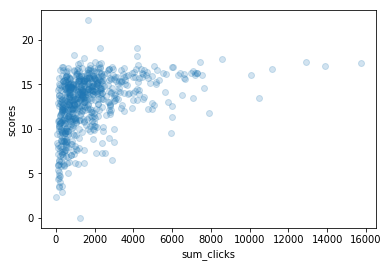

In [41]:
plt.scatter(class_scores_df['sum_click'],class_scores_df['wscore'], alpha=0.2)
plt.xlabel('sum_clicks')
plt.ylabel('scores')
plt.show()

# Statsmodels

Now lets fit an ordinary least squares (ols) model to this and analyze the fit.

As discussed, statsmodels.formula.api prvoides a formula framework for ols like in R.

If you do not want to use the formula structure, you can pass the response and predictor dataframes/matrix to sm.ols. The 'patsy' library provides a convenient way to create the design matrix and dummy encode categorical variables. The section below shows this approach.

### Creating design matrix

In [42]:
formula = 'wscore ~ sum_click + C(highest_education) + C(age_band)'
y, X = patsy.dmatrices(formula, class_scores_df, return_type='dataframe')
X.head()

,Intercept,C(highest_education)[T.HE Qualification],C(highest_education)[T.Lower Than A Level],C(highest_education)[T.Post Graduate Qualification],C(age_band)[T.35-55],C(age_band)[T.55<=],sum_click
0,1.0,1.0,0.0,0.0,0.0,1.0,934.0
1,1.0,1.0,0.0,0.0,1.0,0.0,1435.0
2,1.0,0.0,0.0,0.0,1.0,0.0,2158.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1034.0
4,1.0,0.0,0.0,0.0,1.0,0.0,2445.0


In the formula, C() is used to explicitly indicate that the variable is categorical. This is necessary if the categorical variable has integer/numerical values. However, if the values are of type object, patsy will treat the variable as categorical implicitly 

Let us fit an ols model to the design matrix obtained. The model.summary tabulates all the statistical metrics of the ols fit in a neat fashion

In [43]:
lm1 = sm.OLS(y,X) #initialize model
lm1_model = lm1.fit() #fit the model and obtain results
print(lm1_model.summary()) #summarize results 

                            OLS Regression Results                            
Dep. Variable:                 wscore   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     24.16
Date:                Fri, 30 Mar 2018   Prob (F-statistic):           5.01e-26
Time:                        20:34:42   Log-Likelihood:                -1701.5
No. Observations:                 697   AIC:                             3417.
Df Residuals:                     690   BIC:                             3449.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### Using formlua
However, with the formula.api package we can obtain the above results more conveiniently as it uses patsy under the hood to create your desing matrix. This is illustrated below.

In [44]:

# Note: the command dir.smf produces a list of all the models that are supported by the statsmodels.formula.api. 
# You will have to resort to statsmodels.api and use patsy (as shown above) -
                                                        # for those that are not supported by the formula framework.

dir(smf)[:10]

['GEE',
 'GLM',
 'GLS',
 'GLSAR',
 'Logit',
 'MNLogit',
 'MixedLM',
 'NegativeBinomial',
 'NominalGEE',
 'OLS']

On fitting an ols model to the formula we obtain the same results as the lm1.model above :-

In [45]:
formula = 'wscore ~ sum_click + highest_education + age_band'
lm2 = smf.ols(formula, class_scores_df)
lm2_model = lm2.fit()
print(lm2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 wscore   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     24.16
Date:                Fri, 30 Mar 2018   Prob (F-statistic):           5.01e-26
Time:                        20:34:42   Log-Likelihood:                -1701.5
No. Observations:                 697   AIC:                             3417.
Df Residuals:                     690   BIC:                             3449.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

### Interpreting results 

The summary results has a lot of good information about the fit. A few common/imprtant metrics are listed below: 
- coef  : gives us the regression coeffecient of the corresponding variable. This has the following interpretation 
    - lets take sum_click with a coeffecient of 0.0007 for example.
    - Interpretation : Holding all other variables constant, for an increase in 1 unit in sum_click, the student's assessment score (wscore) will increase by 0.007.
- P>|t| : p value to test the hypothesis that coeffecients significantly different from zero. p-value's lower that 0.05 indicate a that the coeffecients are significant (at 95%).  
    - In our case we find that the coeff of sum_click, age_band[T.55<=] and the intercept are statistically significant and the others are not.    


A detailed discussion of these metrics is beyond the scope of this tutorial. For more detail please refer to
- http://connor-johnson.com/2014/02/18/linear-regression-with-python/ 





Earlier we noticed that the relationship between wscore vs sum-click was not strictly linear. Let us take a look at the descriptive statistics of sum_click

In [46]:
class_scores_df.describe()

,sum_click,wscore
count,697.000000,697.000000
mean,1771.595409,13.013814
std,1816.323018,3.059626
min,20.000000,0.000000
25%,611.000000,11.280000
50%,1265.000000,13.600000
75%,2196.000000,15.340000
max,15716.000000,22.200000


We find that the range of values (min-max) for 'sum_click' very large. Also, lets take a look at its distribution. 

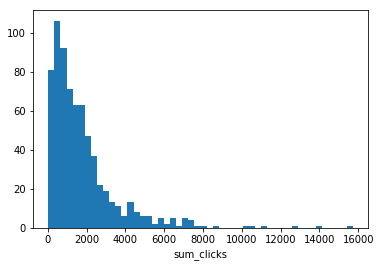

In [47]:
#distribution of sum_click
plt.hist(class_scores_df['sum_click'], bins=50)
plt.xlabel('sum_clicks')
plt.show()


The distribution seems to be skewed right. Ideally we would want it to be normal to make the best inferences. Lets see if a log transformation helps.

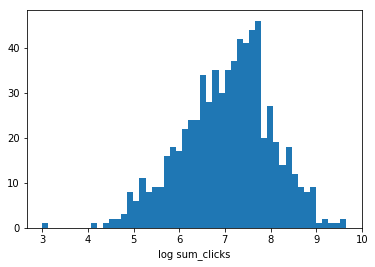

In [48]:
#dist of log sum_clicks
log_clicks = np.log(class_scores_df['sum_click'])
plt.hist(log_clicks, bins=50)
plt.xlabel('log sum_clicks')
plt.show()

#more normal -> satisfies underlying assumptions

The distrbution does seem more normal. 

This time on plotting scores agains log(sum_click) we find that the trend is more linear.

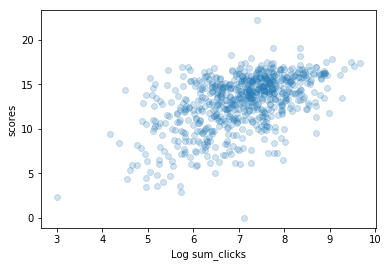

In [49]:
plt.scatter(np.log(class_scores_df['sum_click']),class_scores_df['wscore'], alpha=0.2)
plt.xlabel('Log sum_clicks')
plt.ylabel('scores')
plt.show()

#shows better linear trend

Now let us fit an ols model to this transformed data.
The formula framework allows you a apply this transformation function conveiniently as follows


In [50]:
formula = 'wscore ~ np.log(sum_click) + highest_education + age_band' #'wscore ~ sum_click + highest_education + age_band'
lm3 = smf.ols(formula, class_scores_df)
lm3_model = lm3.fit()
print(lm3_model.summary())


                            OLS Regression Results                            
Dep. Variable:                 wscore   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     48.69
Date:                Fri, 30 Mar 2018   Prob (F-statistic):           6.89e-50
Time:                        20:34:43   Log-Likelihood:                -1644.9
No. Observations:                 697   AIC:                             3304.
Df Residuals:                     690   BIC:                             3336.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

#### Interactions
Now if you want to add interaction terms to your model, for example if you want to add an interaction term between sum_click and education level (highest education), you can do so as follows

In [51]:
#lets you model interactions
interaction_lm = smf.ols('wscore ~ highest_education*np.log(sum_click) + age_band', class_scores_df)
imodel = interaction_lm.fit()
print(imodel.summary())

                            OLS Regression Results                            
Dep. Variable:                 wscore   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     32.64
Date:                Fri, 30 Mar 2018   Prob (F-statistic):           7.72e-48
Time:                        20:34:43   Log-Likelihood:                -1643.9
No. Observations:                 697   AIC:                             3308.
Df Residuals:                     687   BIC:                             3353.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

### endog and exog
The results instance has a reference to the response and predictor matrices. They can be accessed as follows 

Note the following terminologies in the statistics world: 
   - endog is the matrix of the endogeneous variable or the response
   - exog is the matrix of the exogenous variables or the predictors

In [52]:
exog = lm3_model.model.exog
endog = lm3_model.model.endog
print(exog) #design matrix
print(endog[:10]) #response

[[ 1.          1.          0.         ...,  0.          1.          6.83947644]
 [ 1.          1.          0.         ...,  1.          0.          7.26892013]
 [ 1.          0.          0.         ...,  1.          0.          7.67693715]
 ..., 
 [ 1.          0.          0.         ...,  1.          0.          5.54907608]
 [ 1.          0.          1.         ...,  1.          0.          8.8040249 ]
 [ 1.          0.          0.         ...,  1.          0.          4.60517019]]
[ 16.48  13.08  15.26  11.    13.38  13.56  14.5   14.24  15.8   14.8 ]


In [53]:
#if we want the exog as a datafraem
lm3_model.model.data.orig_exog.head()

,Intercept,highest_education[T.HE Qualification],highest_education[T.Lower Than A Level],highest_education[T.Post Graduate Qualification],age_band[T.35-55],age_band[T.55<=],np.log(sum_click)
0,1.0,1.0,0.0,0.0,0.0,1.0,6.839476
1,1.0,1.0,0.0,0.0,1.0,0.0,7.268920
2,1.0,0.0,0.0,0.0,1.0,0.0,7.676937
3,1.0,0.0,1.0,0.0,0.0,0.0,6.941190
4,1.0,0.0,0.0,0.0,1.0,0.0,7.801800


### Prediction

Finally we can also use our model to predict the reponse. 
For example, if we want to predict the weighted score for a student with 1500 clicks, who has a 'Lower than A level' eduction and is in the age group 35-55 years, we can do so by passing these values in an array-like data structure to the results.predict function.

In [54]:
#now if you want to predict :
#you can pass array like parameters to predict for a data point
lm3_model.predict({'sum_click': [1500], 'highest_education': ['Lower Than A Level'], 'age_band':['35-55']})

0    12.76578
dtype: float64

In [55]:
#This means you could also pass a dataframe
test_df = pd.DataFrame({'sum_click': [1500], 'highest_education': ['Lower Than A Level'], 'age_band':['35-55']})
lm3_model.predict(test_df)

0    12.76578
dtype: float64

In [56]:
#you can predict for multiple data points as well
lm3_model.predict(class_scores_df).head()

0    11.723045
1    13.511407
2    13.889870
3    12.740907
4    14.109951
dtype: float64

### Garaphics
At this point you might be irking to visualize your data to get a better sense of the fit. The graphics classes in Statsmodels lets you do this. We will explore a few of these plots along the way. Note that these calls use matplotlib under the hood. 

We will use the lm3_model that was fit earlier in this section.

We might want to get a sense for the fit against a particular predictor. The plot_fit() function lets you visualize the fitted values agains the actual values. Let us check it out for sum_clicks

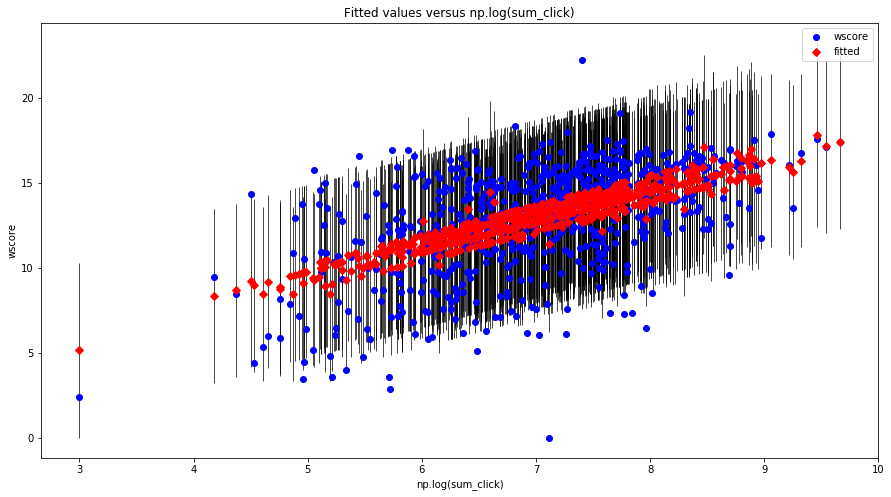

In [57]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.plot_fit(lm3_model, 'np.log(sum_click)', ax=ax)

The black lines indicate the 95% confidence interval.

Since we are dealing with multiple regression, we may want to look at partial regression plots (or added variable plots) with respect to particular predictor. At a high level, a partial regression plot of the response and a particular variable gives us the effect of that variable on the response by taking into consideration the effect of the other explanatory variables as well. 

In the call to the plot_partregress() function below, the first argument is the response, second is the variable whose effect we want to capture and the third agrument is a list of all the other variables in the multivariate regression.

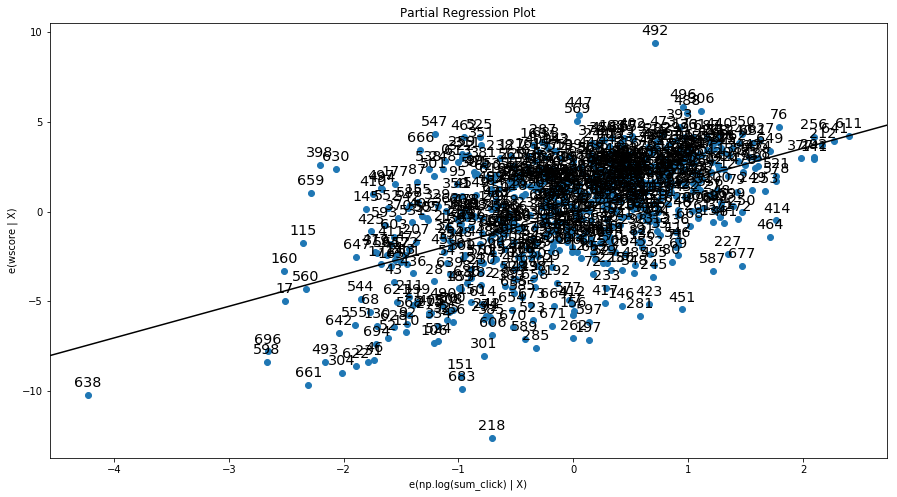

In [58]:
fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.plot_partregress('wscore','np.log(sum_click)' , ['highest_education', 'age_band'],  ax=ax, data=class_scores_df)

Notice how data point 218 seems to be an outlier. Added variable plots are useful to identify influential data points. I will address this in more detail in a later part of this tutorial

Further, we can also get a a quick look up of the partial regression plots for each variable by calling plot_partregress_grid(). However, notice that the observations are not labelled in this case

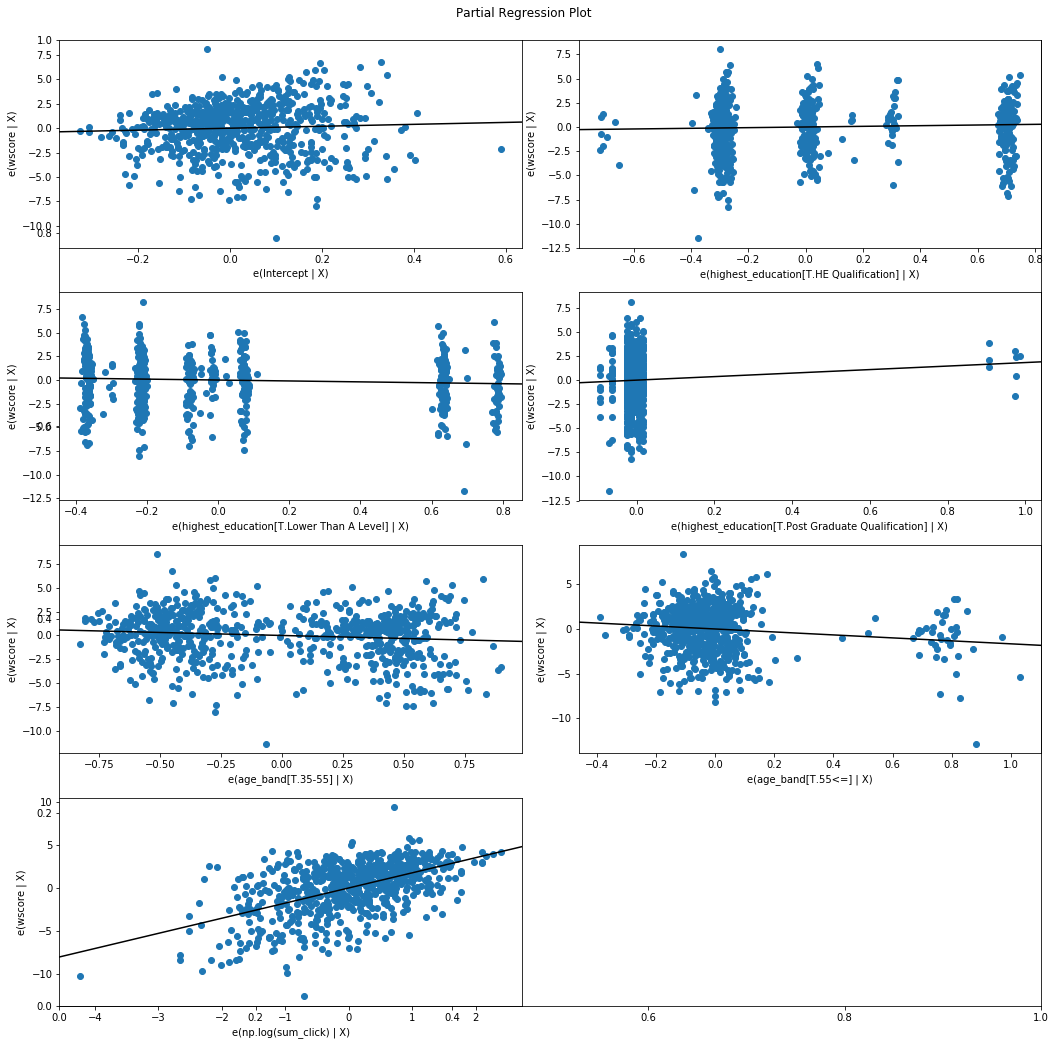

In [59]:
fig, ax = plt.subplots(figsize=(15,15))
fig = sm.graphics.plot_partregress_grid(lm3_model, fig=fig)

### Residuals

At this point you might want to take a look at the residuals and further perform outlier analysis. You can get the residuals by calling the resid attribute of the results instance. Also, let us visualize this.

In [60]:
residuals = lm3_model.resid
residuals.head()

0    4.756955
1   -0.431407
2    1.370130
3   -1.740907
4   -0.729951
dtype: float64

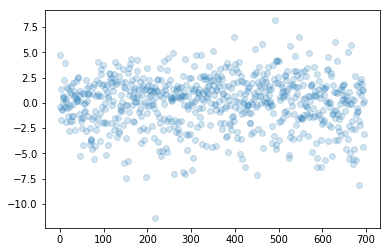

In [61]:
#lets plot this
plt.scatter(residuals.index,residuals, alpha=0.2)
plt.show()

We can also get the residual plot by calling plot_regress_exog() which renders a neat set of plots that summarize the fit.


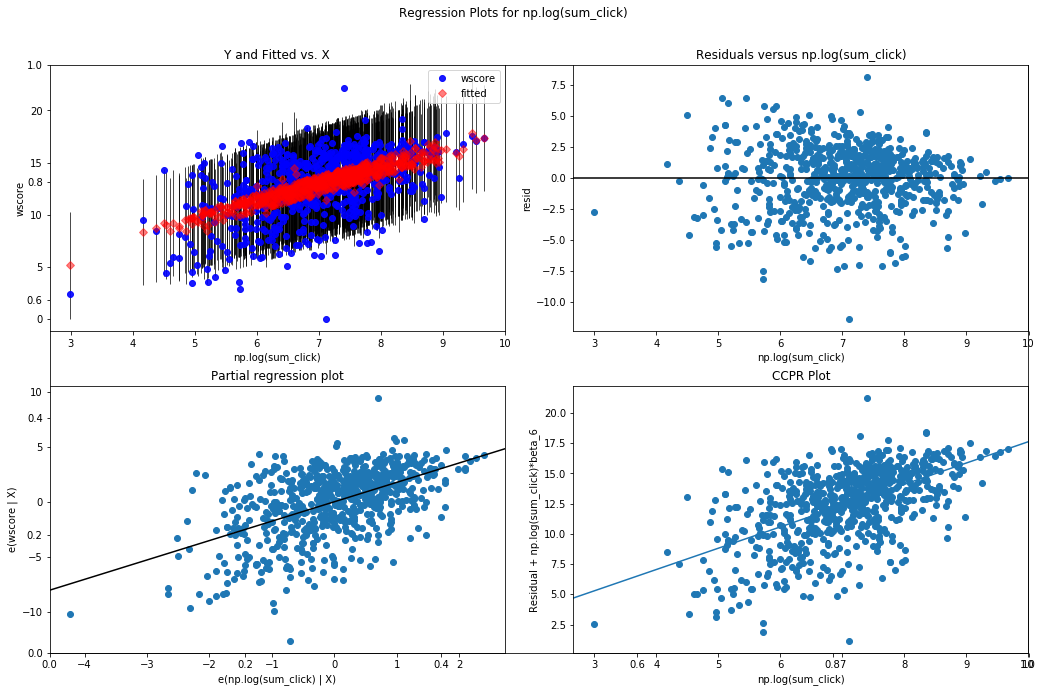

In [62]:
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(lm3_model, 'np.log(sum_click)', fig=fig)

### Outlier Analysis  

Now if you suspect that your data has outliers or if you want to test for outliers then you can perform outlier test with statsmodels. OLSResults.outlier_test() will return the studentized residuals with the unadjusted and corrected p-values. uses the bonferroni : one-step correction method by default. 

A quick note on 'studentized' residuals - When the data contains large outlier, they tend to pull the regression function towards them such that we cannot identify them as outliers by looking at the 'standardized' residuals (as they would be small). In these cases we use studentized residuals as an alternative for identifying outliers.
(ref : https://onlinecourses.science.psu.edu/stat462/node/247)

In [63]:
outlier_test = lm3_model.outlier_test() # 
outlier_test.head(100)
outlier_test.sort_values(by=['unadj_p']).head()

,student_resid,unadj_p,bonf(p)
218,-4.560610,0.000006,0.004207
683,-3.205333,0.001411,0.983701
492,3.197371,0.001450,1.000000
151,-2.920557,0.003608,1.000000
197,-2.888509,0.003992,1.000000


The above output suggests that observation number 218 is an outlier with a bonferroni p-value < 0.05

Further, you may want to get other influence measures of each data point.Influence of an observation is a combination of its 'descrepancy' ( a measure of unusal response) and leverage (a measure of unusal predictor). You can conveniently do this by calling the getInfluence() method of the OLSresults object which returns an influence instance.

In [64]:
influence = lm3_model.get_influence()
influence.summary_frame().head(10)

,dfb_Intercept,dfb_highest_education[T.HE Qualification],dfb_highest_education[T.Lower Than A Level],dfb_highest_education[T.Post Graduate Qualification],dfb_age_band[T.35-55],dfb_age_band[T.55<=],dfb_np.log(sum_click),cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
0,0.081714,0.058139,-0.004478,-0.044430,0.029880,0.278453,-0.088034,1.452964e-02,0.319499,0.318916,0.028162,1.873441,1.876862
1,0.000270,-0.011206,0.001325,-0.000316,-0.007063,0.002245,0.000587,3.375263e-05,-0.015360,-0.015371,0.008283,-0.168190,-0.168072
2,-0.006693,-0.015666,-0.019133,-0.004952,0.019982,0.000908,0.009144,2.036968e-04,0.037741,0.037761,0.004989,0.533280,0.533004
3,0.003258,-0.000938,-0.052717,-0.002438,0.037596,0.013183,-0.008092,6.421876e-04,-0.067021,-0.067047,0.009651,-0.679187,-0.678921
4,0.005004,0.008403,0.010169,0.002638,-0.010227,-0.000083,-0.006347,6.020758e-05,-0.020516,-0.020529,0.005193,-0.284140,-0.283950
5,0.004140,-0.016973,-0.001908,-0.001552,0.010613,0.009633,-0.005538,7.698208e-05,-0.023198,-0.023214,0.008298,-0.253773,-0.253601
6,-0.002452,-0.007812,-0.005729,-0.001395,-0.011243,-0.004887,0.006499,4.969351e-05,0.018638,0.018651,0.004574,0.275140,0.274956
7,0.000402,0.000570,0.000407,0.000100,0.000873,0.000414,-0.000699,2.948095e-07,-0.001436,-0.001437,0.005264,-0.019747,-0.019733
8,-0.001496,-0.004775,0.000433,0.065568,-0.003342,0.018462,0.001642,7.774074e-04,0.073717,0.073769,0.136246,0.185740,0.185610
9,-0.001365,0.000594,0.054929,-0.000564,0.022176,0.001784,-0.001453,8.108797e-04,0.075328,0.075340,0.007260,0.880980,0.880837


The above table has all information that would let us analyze outliers and leverage points.

The 'dfb_beta' columns gives us the estimate of the coeffecient on omitting the corresponding observation. 
'hat_diag' is the diagonal of the hat matrix where in the hat-value is a measure of the leverage of that observation. Unusually large hat-values are noteworthy. 

The column, 'cooks_d' gives us a measure of discrepency (outliers) and leverage combined (influence). Once again unusually large cooks distance are noteworthy. 

Let us take a look at these measures for observation 218 that we had identified as an outlier.


#ref: http://polisci.msu.edu/jacoby/icpsr/regress3/lectures/week3/11.Outliers.pdf

In [65]:
d = influence.summary_frame()
d[d.index ==218]

,dfb_Intercept,dfb_highest_education[T.HE Qualification],dfb_highest_education[T.Lower Than A Level],dfb_highest_education[T.Post Graduate Qualification],dfb_age_band[T.35-55],dfb_age_band[T.55<=],dfb_np.log(sum_click),cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
218,-0.132214,0.165959,-0.315027,0.119912,0.024563,-0.731117,0.137122,0.102403,-0.858713,-0.846652,0.034239,-4.496553,-4.56061


As expected, cooks-d value is relatively large confirming the that this point is influential.

We can visualize this with an influence plot


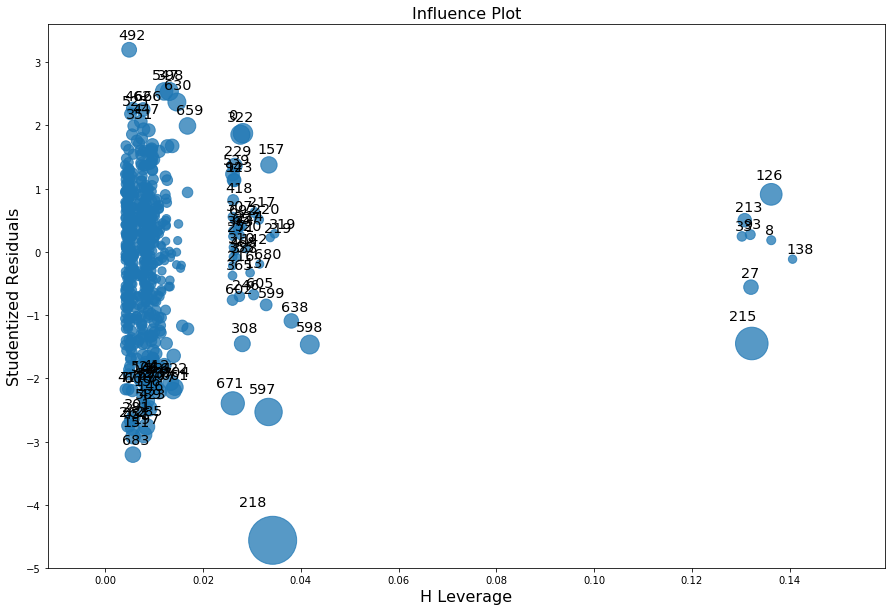

In [66]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.influence_plot(lm3_model, ax=ax, criterion="cooks")

### Robust linear model

From the graph above, we note that observation 218 and 215 have a high influence on the fit 

In case your dataset is affected by a lot of discrepencies or leverages, you might want to consider robust linear models. robust linear models lets you weight the observations while fitting the model. This often is a good alternative to omitting the outliers or blindly including them in the OLS fit (ref :https://stats.idre.ucla.edu/r/dae/robust-regression/) 

Let us take a quick look at how we can fit a robust linear model to our data using statsmodels. Statsmodels offers a wide range of weighting functions (or norms) that we can use.

In this case we use the hubert's criterion (the default criterion). Lets analyze the outcome.

In [67]:
rlm1 = sm.RLM(endog, exog, M=sm.robust.norms.HuberT()).fit()
print(rlm1.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  697
Model:                            RLM   Df Residuals:                      690
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 30 Mar 2018                                         
Time:                        20:34:51                                         
No. Iterations:                    20                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1842      0.719      1.646      0.1

Further, we can see the weights assigned to each data point by calling rlmResults.weights()

In [68]:
print(rlm1.weights[:25]) # first 25 data points
print(rlm1.weights[218]) # for extreme observation 218

[ 0.73541715  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          0.8392828   1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.        ]
0.272342579864


Looking at the weight assigned to the influential observation# '218', we find that this data point as been assigned a lower weight (less than 1) based on HubertT criterion

### Logistic regression:

Finally for the case where the response has discrete values, statsmodels lets you fit dicrete models. To illustrate this lets turn to another dataset compiled from OULAD where now the response (final_result) has 3 values - Pass, Fail and distinction. 


    

In [69]:
logistic_df = pd.read_csv('logistic_data.csv') #results are pass,fail,distinction
print(logistic_df['final_result'].value_counts())
logistic_df.head()

Pass           23370
Fail            8920
Distinction     5915
Name: final_result, dtype: int64


,code_module,code_presentation,id_student,gender,region,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_type,date_submitted,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,55<=,0,240,N,Pass,TMA,112.4,934
1,AAA,2013J,28400,F,Scotland,HE Qualification,35-55,0,60,N,Pass,TMA,114.2,1435
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,35-55,0,60,N,Pass,TMA,112.2,2158
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,0-35,0,60,N,Pass,TMA,125.6,1034
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,35-55,0,60,N,Pass,TMA,116.2,2445


Now lets try and build a logistic regression model where the response = fail/not_fail 

In [70]:

# The motivation here is : 
#    - to check the statistical significance of the coeff for sum_click
#    - interpret the influence of sum_clicks on the response.
   
# First, lets prepare our response variable by encoding it as fail = 1  and not_fail(pass/distinction) = 0. 


#we are interested in p/f
logistic_df['res'] = np.where(logistic_df['final_result']=='Fail', 1, 0) #1 = fail; 0 = not_fail
logistic_df.head()

,code_module,code_presentation,id_student,gender,region,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_type,date_submitted,sum_click,res
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,55<=,0,240,N,Pass,TMA,112.4,934,0
1,AAA,2013J,28400,F,Scotland,HE Qualification,35-55,0,60,N,Pass,TMA,114.2,1435,0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,35-55,0,60,N,Pass,TMA,112.2,2158,0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,0-35,0,60,N,Pass,TMA,125.6,1034,0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,35-55,0,60,N,Pass,TMA,116.2,2445,0


In [71]:
#choosing vars that we are interested in 
cols = ['res','sum_click', 'code_module','code_presentation', 'gender', 'region', 'highest_education', 'age_band', 'disability', 'assessment_type']
logistic_df = logistic_df[cols]

In [72]:
#Building RHS of the formula
all_vars = list(logistic_df.columns.values) 
all_vars.remove('res')
all_vars = '+'.join(all_vars) 
#note smf does not have the y~. feature like  R

formula = 'res~' + all_vars
logit_model = smf.logit(formula , logistic_df).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.441757
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    res   No. Observations:                38205
Model:                          Logit   Df Residuals:                    38172
Method:                           MLE   Df Model:                           32
Date:                Fri, 30 Mar 2018   Pseudo R-squ.:                  0.1871
Time:                        20:34:52   Log-Likelihood:                -16877.
converged:                       True   LL-Null:                       -20762.
                                        LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                       

On investigating the results we find that the coeffecient of sum_click with a p-value of 0 is statistically significant indeed.

It can be interpreted as follows :-
 - Holding all other variables condatnt, 1 unit increase in sum_click would decrease the log-odd of failure by 0.12%
 
 
A detailed analysis of logistic regression can be found at - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936971/

## References :
- Dataset : https://analyse.kmi.open.ac.uk/open_dataset
- https://www.statsmodels.org/
- https://stackoverflow.com/questions/14573728/python-statistics-package-difference-between-statsmodel-and-scipy-stats
- https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
- https://www.datasciencecentral.com/profiles/blogs/linear-regression-in-python-use-of-numpy-scipy-and-statsmodels
- http://efavdb.com/interpret-linear-regression/
- https://people.richland.edu/james/ictcm/2004/multiple.html
- http://markthegraph.blogspot.com/2015/05/using-python-statsmodels-for-ols-linear.html
- https://www.journaldev.com/19119/python-statsmodels-statistics
- https://www.youtube.com/watch?v=V86gTgL1FRw